In [1]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

# If you need to determine the percent voxel change between two images follow these steps first. 

## If you already have a "percent.csv" file, skip to next section

In [72]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"
affinefile = os.path.join(src, "output_dirs/PRAfMRIr_to_PRAm_affine/result.tif")
transformixedfile = os.path.join(src, "output_dirs/PRAfMRIr_to_PRAm/result.tif")
annotationsfilename = os.path.join(src,"labels/labels_v3.csv")
output= "/home/emilyjanedennis/Desktop/PRAfMRIr_to_PRAm_affine_vs_full.tiff"

In [42]:
affine = tif.imread(affinefile)
print("read affine tiff")
transformixed = tif.imread(transformixedfile)
print("read transformixed tiff")

read affine tiff
read transformixed tiff


In [43]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1],header=0,names=['id','abbr'])
print("read annotations")

read annotations


In [44]:
df=anns.dropna()
df

,id,abbr
0,0,Clear Label
1,1,descending corticofugal pathways
2,2,substantia nigra
3,3,subthalamic nucleus
4,4,molecular layer of the cerebellum
...,...,...
114,114,"ventral cochlear nucleus, posterior part"
115,115,"ventral cochlear nucleus, cap area"
116,116,spiral ganglion
117,117,nucleus sagulum


In [45]:
df.insert(2,'affine_vox',0)
df.insert(3,'transformixed_vox',0)


In [46]:
for i in df['id']:
    df.transformixed_vox[df.index[df.id==i]] = np.size(transformixed[transformixed==i])
    df.affine_vox[df.index[df.id==i]] = np.size(affine[affine==i])


<ipython-input-46-ec990ef16611>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transformixed_vox[df.index[df.id==i]] = np.size(transformixed[transformixed==i])
<ipython-input-46-ec990ef16611>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.affine_vox[df.index[df.id==i]] = np.size(affine[affine==i])


In [47]:
df

,id,abbr,affine_vox,transformixed_vox
0,0,Clear Label,214025008,213135410
1,1,descending corticofugal pathways,872434,860624
2,2,substantia nigra,233850,229708
3,3,subthalamic nucleus,8808,8554
4,4,molecular layer of the cerebellum,4423603,4285318
...,...,...,...,...
114,114,"ventral cochlear nucleus, posterior part",858931,869670
115,115,"ventral cochlear nucleus, cap area",990117,964664
116,116,spiral ganglion,0,0
117,117,nucleus sagulum,0,0


In [48]:
df['change'] = df['affine_vox']-df['transformixed_vox']

In [49]:
df = df[df.transformixed_vox > 0]
df

,id,abbr,affine_vox,transformixed_vox,change
0,0,Clear Label,214025008,213135410,889598
1,1,descending corticofugal pathways,872434,860624,11810
2,2,substantia nigra,233850,229708,4142
3,3,subthalamic nucleus,8808,8554,254
4,4,molecular layer of the cerebellum,4423603,4285318,138285
...,...,...,...,...,...
110,110,"secondary auditory cortex, dorsal area",268270,273572,-5302
112,112,auditory radiation,220677,218261,2416
113,113,"ventral cochlear nucleus, anterior part",326085,327245,-1160
114,114,"ventral cochlear nucleus, posterior part",858931,869670,-10739


In [50]:
dfpercent = (df['change']/df['transformixed_vox'])*100
dfpercent[np.isinf(dfpercent)]=0
df['percent'] = dfpercent
dfpercent.replace(0,np.nan)

<ipython-input-50-fce1c83d1c49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent'] = dfpercent


0      0.417386
1      1.372260
2      1.803159
3      2.969371
4      3.226948
         ...   
110   -1.938064
112    1.106932
113   -0.354474
114   -1.234836
115    2.638535
Length: 72, dtype: float64

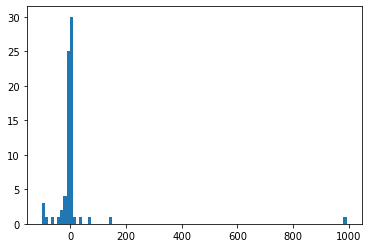

In [51]:
plt.hist(df.percent,bins=100)
plt.show()

In [52]:
mp = np.nanmedian(df.percent)
sp = np.nanstd(df.percent)

In [53]:
highmp = mp+sp
highmp

118.6933632445605

In [54]:
lowmp = mp-sp
lowmp

-122.81388906998312

In [55]:
percentcsv="/home/emilyjanedennis/Desktop/percent.csv"
df.to_csv(percentcsv)

In [56]:
df=pd.read_csv(percentcsv)

In [57]:
df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,0,Clear Label,214025008,213135410,889598,0.417386
1,1,1,descending corticofugal pathways,872434,860624,11810,1.372260
2,2,2,substantia nigra,233850,229708,4142,1.803159
3,3,3,subthalamic nucleus,8808,8554,254,2.969371
4,4,4,molecular layer of the cerebellum,4423603,4285318,138285,3.226948
...,...,...,...,...,...,...,...
67,110,110,"secondary auditory cortex, dorsal area",268270,273572,-5302,-1.938064
68,112,112,auditory radiation,220677,218261,2416,1.106932
69,113,113,"ventral cochlear nucleus, anterior part",326085,327245,-1160,-0.354474
70,114,114,"ventral cochlear nucleus, posterior part",858931,869670,-10739,-1.234836


In [59]:
too = df.id


In [60]:
transformixed_relative = transformixed

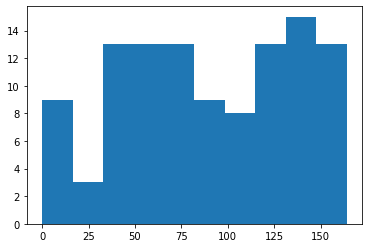

In [67]:
# add list of unique values not in twoxh/twoxl but in transformixed
x = np.unique(affine)
plt.hist(x)
plt.show()

In [68]:
test = np.setdiff1d(x,too)
test[1:20]

array([120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139], dtype=int16)

In [69]:
for i in test:
    transformixed_relative[transformixed_relative==i]=0

In [70]:
for i in too:
    transformixed_relative[transformixed_relative==i]=df.loc[df['id']==i,'percent'].iloc[0]

In [73]:
tif.imsave(output,transformixed_relative)

# If you already have a percent file

In [74]:
df=pd.read_csv(percentcsv)

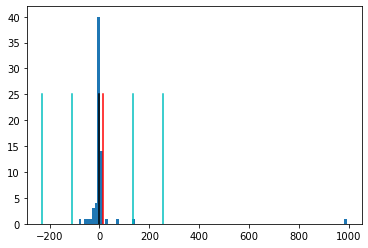

In [75]:
plt.hist(df.percent[df.affine_vox>5],bins=100)

dfmean = np.nanmean(df.percent[df.affine_vox>5])
dfmedian = np.nanmedian(df.percent[df.affine_vox>5])
dfstd = np.std(df.percent[df.affine_vox>5])
mp = dfmean + dfstd
mm = dfmean - dfstd

mp2 = dfmean + 2*dfstd
mp3 = dfmean + 3*dfstd
mm2 = dfmean - 2*dfstd
mm3 = dfmean - 3*dfstd


plt.plot([dfmean, dfmean],[0,25],'r')
plt.plot([dfmedian, dfmedian],[0,25],'k')
plt.plot([mp,mp],[0,25],'c')
plt.plot([mm,mm],[0,25],'c')
plt.plot([mp2,mp2],[0,25],'c')
plt.plot([mm2,mm2],[0,25],'c')
plt.show()

In [76]:
# want to make summary -- ideally show a ranked 3, 2, 1std>mean 
# in diff colors, and then the 
# values either written or in bar form on the right

df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,0,Clear Label,214025008,213135410,889598,0.417386
1,1,1,descending corticofugal pathways,872434,860624,11810,1.372260
2,2,2,substantia nigra,233850,229708,4142,1.803159
3,3,3,subthalamic nucleus,8808,8554,254,2.969371
4,4,4,molecular layer of the cerebellum,4423603,4285318,138285,3.226948
...,...,...,...,...,...,...,...
67,110,110,"secondary auditory cortex, dorsal area",268270,273572,-5302,-1.938064
68,112,112,auditory radiation,220677,218261,2416,1.106932
69,113,113,"ventral cochlear nucleus, anterior part",326085,327245,-1160,-0.354474
70,114,114,"ventral cochlear nucleus, posterior part",858931,869670,-10739,-1.234836


In [77]:
df2p = df[df.percent>mp]
df2p = df2p.sort_values('percent',ascending=False)
df2m = df[df.percent < mm]
df2m = df2m.sort_values('percent',ascending=False)

In [78]:
df2m=df2m.drop_duplicates('id')

In [79]:
df2p=df2p.drop_duplicates('id')

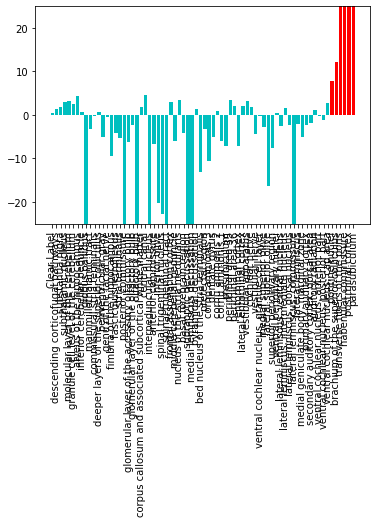

In [89]:
dfforplot = df[df.percent>5]
dfforplot2 = df[df.percent<5]
dfforplot2 = dfforplot2.drop_duplicates('id')
dfforplot = dfforplot.drop_duplicates('id')
plt.bar(dfforplot2.abbr,dfforplot2.percent,color='c')
plt.bar(dfforplot.abbr,dfforplot.percent,color='r')

plt.xticks(rotation=90)
plt.ylim([-25,25])
plt.show()

In [ ]:

plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=6)
plt.ylim([-25,25])
plt.show()